In [0]:
# !python -m spacy download en

In [2]:
# !fusermount -u drive
# !google-drive-ocamlfuse drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os, re, time
from collections import Counter
from os.path import join as joinpath
from tqdm import tqdm
tqdm.pandas()

import pandas as pd
import numpy as np

from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier

import matplotlib
%matplotlib inline

os.getcwd()

'/content'

In [4]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          13022         603       10198           0        2220       12150
Swap:             0           0           0


In [5]:
try:
  os.chdir('drive/My Drive/Colab Notebooks/crowdflower-search-relevance')
  print('Changed directory')
  print(os.getcwd())
except:
  print('Cannot change directory')
  print(os.getcwd())

#setting kaggle json
# !mv .kaggle/kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions submit [-h] -c crowdflower-search-relevance -f data/submission.csv -m rf
# !kaggle competitions submissions  -c crowdflower-search-relevance 

Changed directory
/content/drive/My Drive/Colab Notebooks/crowdflower-search-relevance


In [6]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_train.head()

,id,query,product_title,product_description,median_relevance,relevance_variance
0,1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,NaN,4,0.471
3,5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471


In [7]:
print(len(df_train))
print(len(df_test))

10158
22513


In [8]:
df_train.isna().sum()

id                        0
query                     0
product_title             0
product_description    2444
median_relevance          0
relevance_variance        0
dtype: int64

In [9]:
df_test.isna().sum()

id                        0
query                     0
product_title             0
product_description    5427
dtype: int64

In [10]:
Counter(df_train.median_relevance)

Counter({1: 774, 2: 1476, 3: 1737, 4: 6171})

In [11]:
# df_train = df_train.dropna()
# df_test = df_test.dropna()
# print(len(df_train))
# print(len(df_test))

df_train.fillna('', inplace=True)
df_test.fillna('', inplace=True)
df_train.head()

,id,query,product_title,product_description,median_relevance,relevance_variance
0,1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,,4,0.471
3,5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471


In [12]:
Counter(df_train.median_relevance)

Counter({1: 774, 2: 1476, 3: 1737, 4: 6171})

In [0]:
def remove_numbers(val):
    m = re.findall(r'([A-Za-z]\w+)', val, flags=re.I)
    return ' '.join(m)

stemmer = PorterStemmer()

def text_cleaner(x, append):
  x = BeautifulSoup(x).get_text(" ")
  x = re.sub("[^a-zA-Z0-9]", " ", x)
  x = ' '.join([stemmer.stem(w) for w in x.split()])
  if append:
    return ' '.join([append+w for w in x.split()])
  else:
    return x

In [14]:
text_cleaner('Apples a as as10 1 10 10,333', None)

'appl a as as10 1 10 10 333'

In [15]:
for col in ['query', 'product_title', 'product_description']:
  if col == 'query':
    append = 'q'
  elif col == 'product_title':
    append = 't'
  elif col == 'product_description':
    append = None
  df_train[col] = df_train[col].progress_apply(lambda x: text_cleaner(x, append))
  df_test[col] = df_test[col].progress_apply(lambda x: text_cleaner(x, append))

def truncate(x, max_lenght=40):
  x = x.split()
  return ' '.join(x if len(x)<=max_lenght else x[:max_lenght])

df_train['all_text'] = df_train[['query', 'product_title', 'product_description']].apply(lambda x: ' '.join(x), axis=1)
df_test['all_text'] = df_test[['query', 'product_title', 'product_description']].apply(lambda x: ' '.join(x), axis=1)
df_train['all_text'] = df_train['all_text'].apply(truncate)
df_test['all_text'] = df_test['all_text'].apply(truncate)
df_train.head()

 27%|██▋       | 2760/10158 [00:04<00:11, 646.48it/s]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://i104.photobucket.com/albums/m175/champions_on_display/wincraft2013/januaryb/65497012.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
 35%|███▌      | 3594/10158 [00:05<00:10, 626.26it/s]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://i104.photobucket.com/albums/m175/champions_on_display/wincraft2013/januaryb/65516012.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
 98%|█████████▊| 10005/10158 [00:14<00:00, 731.90it/s]/usr/local/lib

,id,query,product_title,product_description,median_relevance,relevance_variance,all_text
0,1,qbridal qshower qdecor,taccent tpillow twith theart tdesign tred tblack,red satin accent pillow embroid with a heart i...,1,0.000,qbridal qshower qdecor taccent tpillow twith t...
1,2,qled qchristma qlight,tset tof t10 tbatteri toper tmulti tled ttrain...,set of 10 batteri oper train christma light it...,4,0.000,qled qchristma qlight tset tof t10 tbatteri to...
2,4,qprojector,tviewson tpro8200 tdlp tmultimedia tprojector,,4,0.471,qprojector tviewson tpro8200 tdlp tmultimedia ...
3,5,qwine qrack,tconcept thousewar tWR t44526 tsolid twood tce...,like a silent and sturdi tree the southern ent...,4,0.000,qwine qrack tconcept thousewar tWR t44526 tsol...
4,7,qlight qbulb,twintergreen tlight tchristma tled tlight tbul...,wtgr1011 featur nickel base 60 000 averag hour...,2,0.471,qlight qbulb twintergreen tlight tchristma tle...


In [16]:
df_test['all_text'].isna().sum()

0

In [17]:
vocab = ' '.join(df_train['all_text'])
c = Counter(vocab.split()).most_common()
c[:100]

[('the', 7816),
 ('and', 6305),
 ('a', 5034),
 ('with', 4335),
 ('thi', 3828),
 ('to', 3562),
 ('of', 3028),
 ('for', 2764),
 ('is', 2659),
 ('your', 2629),
 ('in', 2254),
 ('ts', 1584),
 ('you', 1482),
 ('s', 1465),
 ('featur', 1437),
 ('tblack', 1082),
 ('design', 1078),
 ('from', 1040),
 ('that', 1023),
 ('on', 987),
 ('or', 890),
 ('twomen', 805),
 ('tfor', 785),
 ('an', 754),
 ('set', 751),
 ('style', 745),
 ('are', 741),
 ('it', 727),
 ('these', 710),
 ('tmen', 700),
 ('t2', 699),
 ('comfort', 672),
 ('tset', 671),
 ('tand', 646),
 ('twith', 638),
 ('t3', 602),
 ('can', 598),
 ('color', 594),
 ('It', 593),
 ('up', 577),
 ('ha', 560),
 ('make', 559),
 ('perfect', 556),
 ('by', 555),
 ('t4', 554),
 ('twhite', 551),
 ('use', 548),
 ('t5', 524),
 ('all', 523),
 ('will', 503),
 ('made', 497),
 ('fit', 494),
 ('includ', 489),
 ('item', 484),
 ('A', 460),
 ('2', 439),
 ('dress', 437),
 ('protect', 425),
 ('tdress', 424),
 ('t1', 419),
 ('ani', 416),
 ('qdress', 409),
 ('look', 407),
 ('

In [0]:
# dirty = []
# for w,_ in c:
#   if len(w) < 4:
#     dirty.append(w)
# dirty

16.26117345934239
2.424788344162237


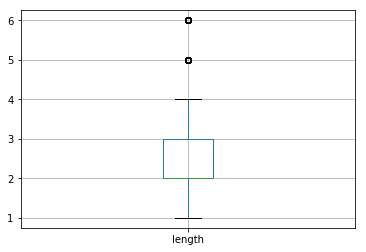

In [19]:
col = 'query'
print(df_train[col].str.len().mean())
df_train['length'] = df_train[col].apply(lambda x: len(x.split()))
print(df_train['length'].mean())
df_train.boxplot(column=['length'])

58.37802717070289
8.963378617838156


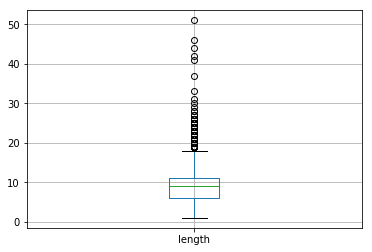

In [20]:
col = 'product_title'
print(df_train[col].str.len().mean())
df_train['length'] = df_train[col].apply(lambda x: len(x.split()))
print(df_train['length'].mean())
df_train.boxplot(column=['length'])

337.30330773774364
63.64619019492026


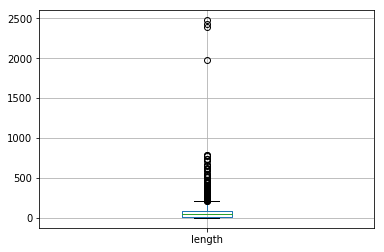

In [21]:
col = 'product_description'
print(df_train[col].str.len().mean())
df_train['length'] = df_train[col].apply(lambda x: len(x.split()))
print(df_train['length'].mean())
df_train.boxplot(column=['length'])

In [0]:
# df_train['median_relevance'] = df_train['median_relevance']/4

In [0]:
# import spacy

# nlp = spacy.load("en_core_web_sm")
# doc = nlp(' '.join(df_train.values))
# for token in doc:
#     print(token.text)

In [24]:
# def get_class_weights(y, one_hot=False):
#     """Returns a dict of class weights for label encoded as well as one-hot encoded y."""
#     if one_hot:
#         y = np.argmax(y, axis=1)
#     classes = np.unique(y)
#     class_weights = class_weight.compute_class_weight('balanced', classes, y)
#     return {c:w for c,w in zip(classes, class_weights)}

# class_weights = get_class_weights(s_labels)

# sw = []
# stop_words = ['http','www','img','border','0','1','2','3','4','5','6','7','8','9','a','the','be','a','about','above','after','again','against','all']
# # stop_words.extend(dirty)
# stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)

# for stw in stop_words:
#     sw.append("q"+stw)
#     sw.append("t"+stw)

# stop_words = text.ENGLISH_STOP_WORDS.union(sw)

tfidf = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
            ngram_range=(1, 5), use_idf=1, smooth_idf=1, 
            sublinear_tf=1, stop_words='english')

#create sklearn pipeline, fit all, and predit test data
clf = Pipeline([('v', tfidf), 
                ('svd', TruncatedSVD(n_components=400, algorithm='randomized', n_iter=6, random_state=None, tol=0.0)), 
                ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), 
                ('svm', SVC(C=10.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, 
                            tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=0))])

print('Fitting model')
clf.fit(df_train['all_text'], df_train['median_relevance'])
print('Making test predictions')
t_labels = clf.predict(df_test['all_text'])
print('Done!')

df_test['prediction'] = t_labels

submission_file_path = 'data/submission.csv'
df_test[['id', 'prediction']].to_csv(submission_file_path, index=False)
print('Submission saved!')

Fitting model
Making test predictions
Done!
Submission saved!
